In [47]:
# Install necessary libraries
# !pip install transformers
# !pip install sentence_transformers

### 1. Importing libraries and news data extraction

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemma = nltk.wordnet.WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import lightgbm as lgbm

from wordcloud import WordCloud
import matplotlib.pyplot as plt 


import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # This option allows make multiple outputs from one cell code

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Connect to Google Drive personal repo
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Uploading our news feed
news_data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/NLP/News_Category_Dataset_v2.json',lines=True)

In [5]:
news_data.shape # Dimension of our dataset
news_data.head(5) # Look at first 5 rows

(200853, 6)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [6]:
# Check some random news description 
news_data['short_description'][100]

'The billionaire Koch brothers’ political network wants to show it will punish Republicans who don’t support its agenda.'

In [8]:
# Let's look news topic distribution
news_data['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [9]:
# Let's limit news topics to 4 groups: Biz/Travel/Entertainment/Politics
# and take only sample of 20K random news (to increase further performance calculation)
news_data_4cat = news_data[news_data['category'].apply(lambda x: x in ['ENTERTAINMENT','TRAVEL','BUSINESS','POLITICS'])].sample(n=20000)

In [10]:
# Updated distribution for 4 topics
news_data_4cat['category'].value_counts()

POLITICS         10135
ENTERTAINMENT     4971
TRAVEL            3058
BUSINESS          1836
Name: category, dtype: int64

### 2. Data cleaning

In [11]:
#  Preprocessing/data cleaning function 
def text_cleaning(text):
    
    # Case lowering 
    text = text.lower()
    # Replacing all special characters including numbers
    text = re.sub('[^A-Za-z]+',' ', text)
    # Transforming text into word list
    text = nltk.word_tokenize(text)
    # Removing stop words
    text = [word for word in text if word not in stopwords.words()]
    # Lemmatizing each tokenized word 
    text = [lemma.lemmatize(word) for word in text]
    # Joining words together 
    text = ' '.join(text)
    
    return text

In [12]:
# Keep only news description and category
%%time
df = pd.DataFrame()
df['Category'] = news_data_4cat['category']
df['description'] = news_data_4cat['short_description'].apply(lambda x: text_cleaning(x)) # description preprocessing

CPU times: user 23min 27s, sys: 1min 48s, total: 25min 15s
Wall time: 25min 45s


In [13]:
# Check if we have empty description in some news
print("News count with empty description: ",df['description'].isna().sum())

# Drop duplicates
print ("News count before deduplication: ", news_data_4cat.shape[0])
df.drop_duplicates(inplace=True)
print ("News count after deduplication: ", df.shape[0])

News count with empty description:  0
News count before deduplication:  20000
News count after deduplication:  17595


In [14]:
# Create dummy variables for the category column 
category = df['Category'].str.get_dummies()
category.columns

Index(['BUSINESS', 'ENTERTAINMENT', 'POLITICS', 'TRAVEL'], dtype='object')

In [15]:
# Define a dataframe data that combines df and category
data = pd.DataFrame(columns=['category','description'],index = None)
data = category
data['description'] = df['description']
data.head(10)

,BUSINESS,ENTERTAINMENT,POLITICS,TRAVEL,description
78535,0,0,1,0,hillary clinton stated vast right wing conspir...
131881,1,0,0,0,part china growing appetite red wine country t...
19865,0,0,1,0,rural veteran far older far likely disabled ru...
185412,0,0,0,1,built french architect pierre stephane duma ne...
70058,0,1,0,0,totally befuddled
125722,0,0,0,1,typical resort vacation caribbean turned excit...
72098,0,0,1,0,includes talent show
70370,0,0,1,0,burn ore ap protest support oregon rancher fac...
4433,0,1,0,0,pacific rim uprising actor producer time ignor...
9500,0,1,0,0,watch quickly fall apart


In [16]:
# Save updated news data in GoogleColab repo
data.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP/news_category_update.csv',index=None)

In [17]:
# Analyzing top significant 2-gram words in the news with TFIDF Vectorizer
def tfidf_counter(desc, category, data, n_gram_min, n_gram_max):
    data = data[data[category]==1]
    vectorizer = TfidfVectorizer(ngram_range=(n_gram_min,n_gram_max), analyzer='word')
    sparse_matrix =  vectorizer.fit_transform(data[desc])
    frequencies = sum(sparse_matrix).toarray()[0]
    return pd.DataFrame(frequencies, index=vectorizer.get_feature_names(), columns=['frequency']).sort_values('frequency', ascending=False)

In [18]:
print("TOP10 significant words for BUSINESS category: \n", tfidf_counter('description', 'BUSINESS', data, 2, 2).head(10))
print("\n TOP10 significant words for POLITICS category: \n", tfidf_counter('description', 'POLITICS', data, 2, 2).head(10))
print("\n TOP10 significant words for TRAVEL category: \n", tfidf_counter('description', 'TRAVEL', data, 2, 2).head(10))
print("\n TOP10 significant words for ENTERTAINMENT category: \n", tfidf_counter('description', 'ENTERTAINMENT', data, 2, 2).head(10))

TOP10 significant words for BUSINESS category: 
                 frequency
wall st          4.324246
united state     4.017755
new york         3.947120
wall street      3.849532
social medium    2.334112
last week        2.032976
according wall   1.857243
central bank     1.798963
across country   1.734624
interest rate    1.583188

 TOP10 significant words for POLITICS category: 
                         frequency
donald trump            63.297933
hillary clinton         29.239860
white house             26.064778
supreme court           17.392717
united state            16.057932
new york                13.664428
bernie sander           13.178790
president trump         12.901803
president elect         11.639985
presidential candidate  11.529786

 TOP10 significant words for TRAVEL category: 
                frequency
new york        9.140028
national park   4.940339
around world    4.560527
york city       3.921749
road trip       3.741004
disney world    3.650948
look like       

### Data visualization with bi-gram word clouds

Cluster: BUSINESS


<Figure size 864x576 with 0 Axes>

(-0.5, 2999.5, 1999.5, -0.5)

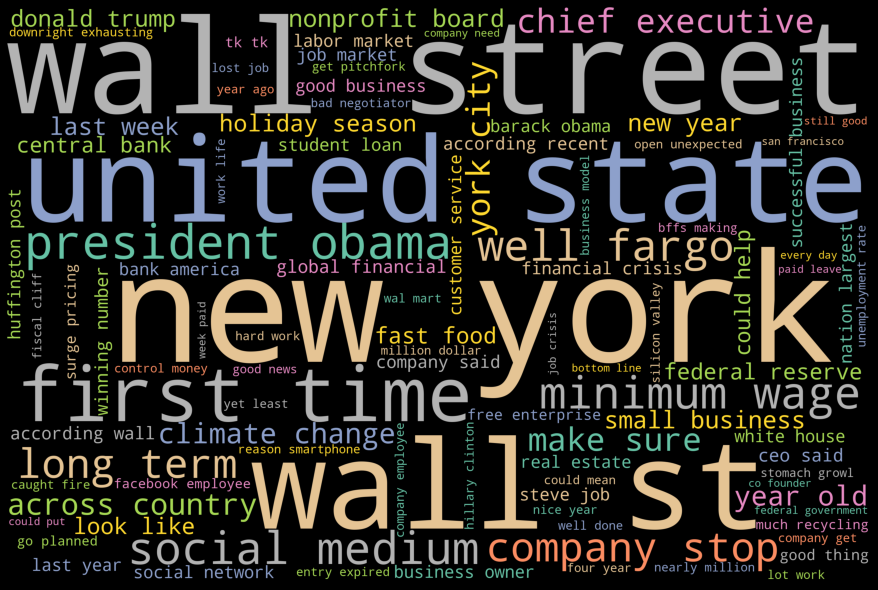

Cluster: ENTERTAINMENT


<Figure size 864x576 with 0 Axes>

(-0.5, 2999.5, 1999.5, -0.5)

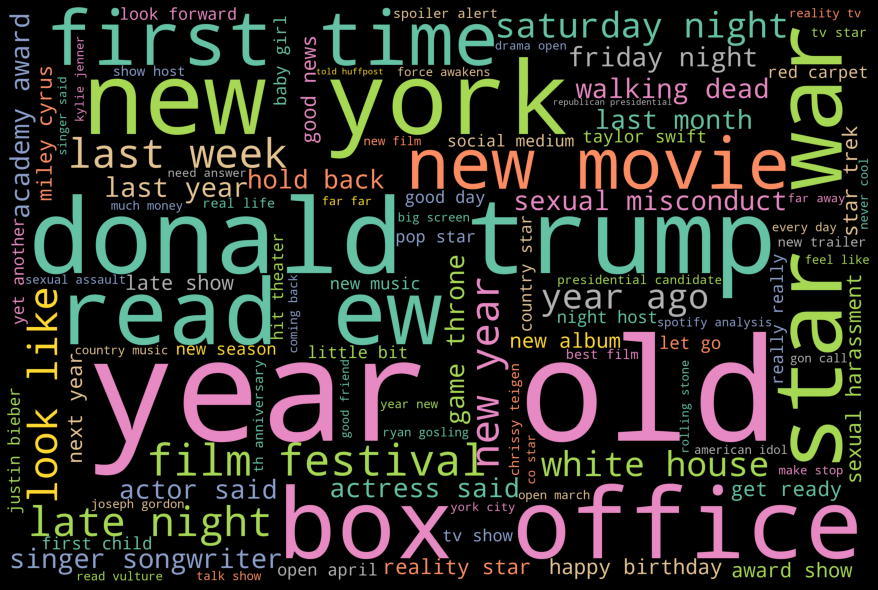

Cluster: POLITICS


<Figure size 864x576 with 0 Axes>

(-0.5, 2999.5, 1999.5, -0.5)

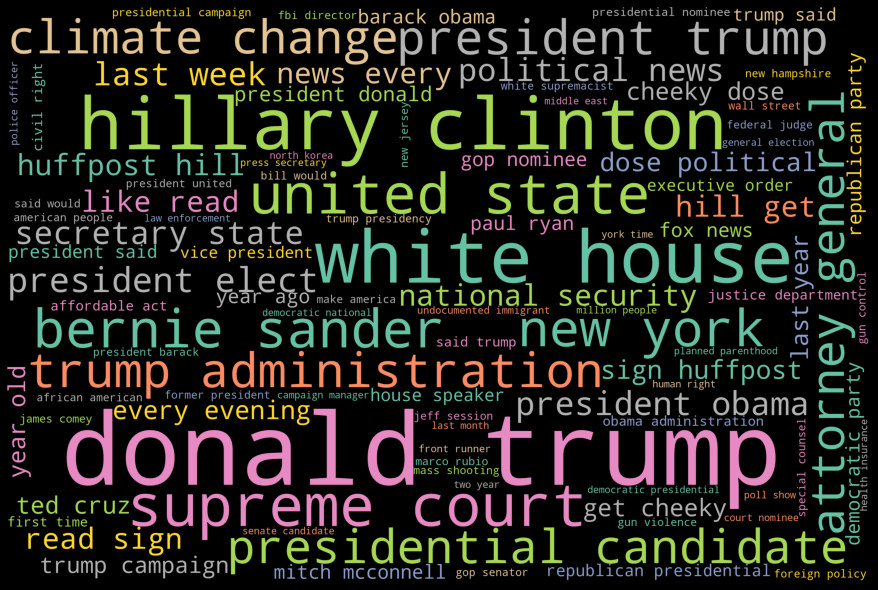

Cluster: TRAVEL


<Figure size 864x576 with 0 Axes>

(-0.5, 2999.5, 1999.5, -0.5)

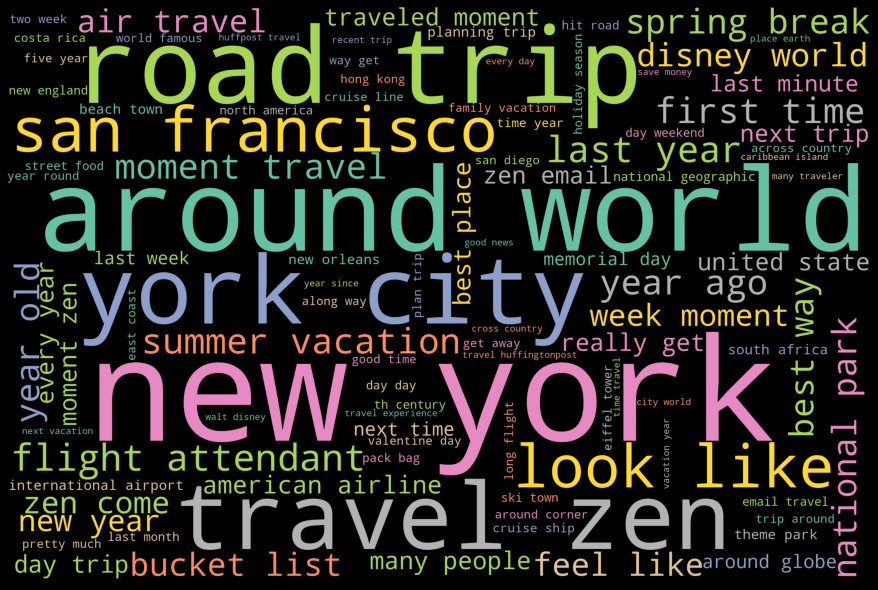

In [ ]:
for column in list(category.columns):
    cluster = data[data[column]==1]
    try:

      d = tfidf_counter('description', column, cluster, 2, 2) # Count TFIDF metric for each category
      frequency = d.T.to_dict('records')[0]
      wordcloud = WordCloud(background_color='black',width=3000, height=2000, max_words=100, 
                            random_state=1, colormap='Set2', collocations=False);
      wordcloud.generate_from_frequencies(frequencies=frequency);
      print('Cluster: {}'.format(column))
      plt.figure(figsize=(12,8), facecolor='k');
      plt.imshow(wordcloud);
      plt.axis("off");
      plt.tight_layout(pad=0);
      plt.show();
    except ValueError:
        continue   

In [33]:
# Split dataset on train/test datasets
df_train, df_test = model_selection.train_test_split(df, test_size=0.2, random_state = 1)

# Get target
y_train = df_train["Category"].values
y_test = df_test["Category"].values

In [34]:
# Tf-Idf Vectorizer for modeling 
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=300, ngram_range=(1,2))

In [35]:
# Fit and transform the Vectorizer based on X_train
corpus = df_train['description']

tfidf_vectorizer.fit(corpus)
X_train = tfidf_vectorizer.transform(corpus)

TfidfVectorizer(max_features=300, ngram_range=(1, 2))

In [36]:
# Estimating what features are significant for each category
y = df_train['Category']
X_names = tfidf_vectorizer.get_feature_names()
p_value_limit = 0.95
df_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    df_features = df_features.append(pd.DataFrame(
                   {'Feature':X_names, 'Score':1-p, 'Category':cat}))
    df_features = df_features.sort_values(['Category','Score'], 
                    ascending=[True,False])
    df_features = df_features[df_features['Score']>p_value_limit]
X_names = df_features['Feature'].unique().tolist()

In [37]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(df_features[df_features['Category']==cat]))
    print("  . top features:", ",".join(
df_features[df_features['Category']==cat]['Feature'].values[:30]))
    print(" ")

# BUSINESS:
  . selected features: 80
  . top features: business,company,job,worker,work,industry,wall,social,trump,pay,percent,president,important,use,republican,according,service,donald,many,leader,tax,make,donald trump,change,party,bad,since,often,start,part
 
# ENTERTAINMENT:
  . selected features: 144
  . top features: actor,film,movie,music,star,president,trump,season,show,state,republican,year old,night,director,hit,donald trump,love,clinton,donald,travel,campaign,government,weekend,democrat,senate,company,gop,old,voter,democratic
 
# POLITICS:
  . selected features: 181
  . top features: campaign,clinton,democrat,donald,donald trump,film,gop,movie,president,republican,state,trump,travel,senate,voter,democratic,actor,election,star,senator,obama,court,season,said,hillary,music,administration,sander,candidate,law
 
# TRAVEL:
  . selected features: 150
  . top features: airline,beach,city,experience,flight,island,local,park,place,summer,town,travel,traveler,trip,trump,vacation,visi

In [38]:
# Fit and transform the Vectorizer based on the feature selection results X_names 
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)


# Testing ML models: Naive Bayes, Random Forest and LightGBM
NB_Classifier = naive_bayes.MultinomialNB()
RForest_Classifier = RandomForestClassifier()
lgbm_Classifier = lgbm.LGBMClassifier()


# NB_Classifier Pipeline with TF-IDF Vectorizer 
NB_Pipeline = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", NB_Classifier)])

# RForest_Classifier Pipeline with TF-IDF Vectorizer 
RForest_Pipeline = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", RForest_Classifier)])

# LGBM_Classifier Pipeline with TF-IDF Vectorizer 
LGBM_Pipeline = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", lgbm_Classifier)])

TfidfVectorizer(vocabulary=['business', 'company', 'job', 'worker', 'work',
                            'industry', 'wall', 'social', 'trump', 'pay',
                            'percent', 'president', 'important', 'use',
                            'republican', 'according', 'service', 'donald',
                            'many', 'leader', 'tax', 'make', 'donald trump',
                            'change', 'party', 'bad', 'since', 'often', 'start',
                            'part', ...])

In [39]:
def model_plot(pipeline):
    # train classifier
    pipeline["classifier"].fit(X_train, y_train)

    # test
    X_test = df_test.description.values
    predicted = pipeline.predict(X_test)
    predicted_prob = pipeline.predict_proba(X_test)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, predicted)
    plt.figure(figsize=(8,8))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="BuPu");  

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['BUSINESS', 'ENTERTAINMENT', 'POLITICS', 'TRAVEL']); ax.yaxis.set_ticklabels(['BUSINESS', 'ENTERTAINMENT', 'POLITICS', 'TRAVEL'])

#### Let's check performance each of 3 classifiers out of the box (standart settings, w/o hyper param tuning)

Naive Bayes Classifier performance:



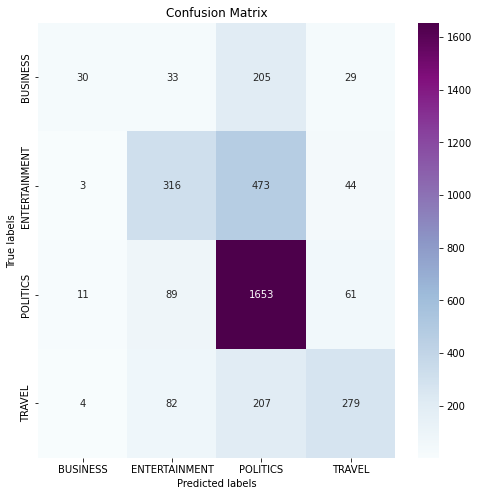

In [40]:
print("Naive Bayes Classifier performance:\n")
model_plot(NB_Pipeline);

RandomForest Classifier performance:



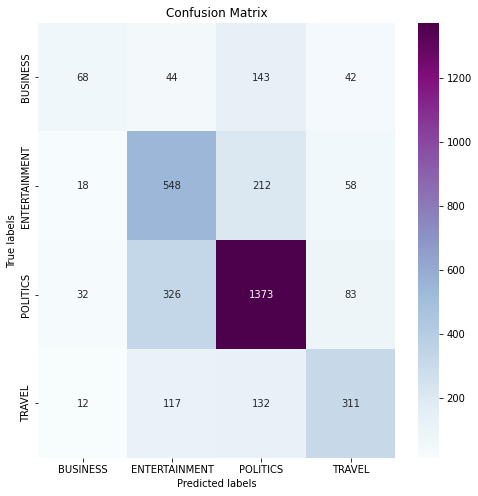

In [41]:
print("RandomForest Classifier performance:\n")
model_plot(RForest_Pipeline)

Light GradientBoosting Classifier performance:



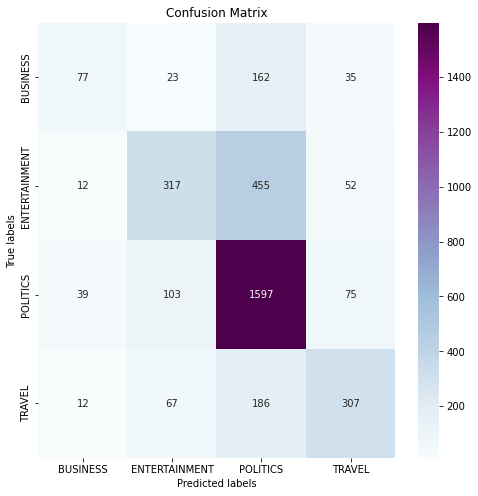

In [42]:
print("Light GradientBoosting Classifier performance:\n")
model_plot(LGBM_Pipeline)

#### Classification report for all 3 classifiers

In [43]:
# Test predictions for all 3 classifiers
X_test = df_test.description.values
predicted_lgbm = LGBM_Pipeline.predict(X_test)
predicted_nb = NB_Pipeline.predict(X_test)
predicted_rf = RForest_Pipeline.predict(X_test)

In [44]:
print('\nClassification Report for NaiveBayes Classifier\n')
print(classification_report(y_test, predicted_nb
                            , target_names=['BUSINESS', 'ENTERTAINMENT', 'POLITICS', 'TRAVEL']));
print('\nClassification Report for RandomForest Classifier\n')
print(classification_report(y_test, predicted_rf
                            , target_names=['BUSINESS', 'ENTERTAINMENT', 'POLITICS', 'TRAVEL']))
print('\nClassification Report for LightGBM Classifier\n')
print(classification_report(y_test, predicted_lgbm
                            , target_names=['BUSINESS', 'ENTERTAINMENT', 'POLITICS', 'TRAVEL']))


Classification Report for NaiveBayes Classifier

               precision    recall  f1-score   support

     BUSINESS       0.62      0.10      0.17       297
ENTERTAINMENT       0.61      0.38      0.47       836
     POLITICS       0.65      0.91      0.76      1814
       TRAVEL       0.68      0.49      0.57       572

     accuracy                           0.65      3519
    macro avg       0.64      0.47      0.49      3519
 weighted avg       0.64      0.65      0.61      3519


Classification Report for RandomForest Classifier

               precision    recall  f1-score   support

     BUSINESS       0.52      0.23      0.32       297
ENTERTAINMENT       0.53      0.66      0.59       836
     POLITICS       0.74      0.76      0.75      1814
       TRAVEL       0.63      0.54      0.58       572

     accuracy                           0.65      3519
    macro avg       0.61      0.55      0.56      3519
 weighted avg       0.65      0.65      0.65      3519


Classificat

#### As we can see, all 3 classifiers show the same accuracy rate.

#### NEXT STEP: Let's try transform our description news to embeddings by using state-of-the-art BERT model

### BERT tokenization

In [48]:
# Extract DistilBERT transformer model
%%time
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('distilbert-base-uncased-finetuned-sst-2-english') #We will use DistilBert ("Light" BERT model)

# Let's make BERT embeddings from news description
X_train_vec = pd.DataFrame(np.vstack(df_train['description'].apply(bert.encode)))
X_test_vec = pd.DataFrame(np.vstack(df_test['description'].apply(bert.encode)))

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 15min 9s, sys: 7.22 s, total: 15min 16s
Wall time: 15min 37s


In [49]:
# Check dimension of our embedding matrix for train/test
X_train_vec.shape
X_test_vec.shape
# Check how look embeddings for first 5 news
X_train_vec.head(5)

(14076, 768)

(3519, 768)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.271707,0.477324,-0.352694,-0.539126,-0.515640,0.506284,0.758453,0.412437,0.150613,-0.479986,0.328505,-0.524767,-0.445520,0.574772,-0.668160,0.592194,0.254792,-0.043128,-0.011557,0.145125,0.371679,0.121045,-0.050585,0.542915,0.479828,0.201148,0.913181,0.015552,-0.352889,0.147140,0.206711,0.340879,0.588330,-0.506166,0.369030,-0.394522,-0.507830,0.408044,-0.056165,0.328996,...,-0.369444,-0.568302,-0.303190,0.075080,-0.730664,-0.667528,1.006612,0.071013,-0.362357,1.061401,-0.078138,0.148937,0.170563,-0.407253,0.652486,-0.592899,0.696830,0.066210,-0.156825,-0.143159,0.206163,-0.510839,-0.338112,0.175506,-0.045765,-0.083013,-0.142336,-0.704713,0.005620,0.341274,0.573903,0.064639,-0.121313,-0.784419,0.564617,-0.343998,0.215890,-0.736877,0.014575,0.152275
1,-0.552384,0.304591,0.209364,-0.407442,-0.322515,0.268996,-0.311810,0.108271,0.091570,0.194254,0.101287,-0.447817,-0.142376,0.191475,-0.362785,0.296366,0.204699,0.062792,0.077370,-0.201562,0.278023,-0.277385,0.361720,-0.229651,0.541015,0.215130,0.079536,0.229393,-0.953486,0.307227,-0.053362,0.306422,0.039399,-0.268820,0.423676,0.064217,-0.212778,-0.035318,-0.493575,-0.100995,...,-0.733050,-0.229174,-0.318035,-0.272803,-0.344256,-0.393855,0.441160,0.119058,-0.060722,0.471923,-0.382698,0.199913,0.321894,-0.313463,0.275426,-0.210851,0.201223,0.307236,-0.296349,-0.394925,0.172313,-0.184388,-0.293017,-0.253657,0.327671,-0.036497,-0.051289,-0.803397,-0.221140,-0.141839,0.510572,0.067250,-0.232844,-0.961309,0.863072,-0.597453,0.401770,-0.000338,0.457094,0.141271
2,-0.243691,0.829251,0.230804,-0.250075,-0.095843,-0.614561,0.560413,0.573294,0.235004,0.038031,0.184661,-0.259440,-0.455438,0.297736,-0.079046,0.410141,0.667321,0.385568,0.311631,0.433313,0.454740,-0.434517,-0.206318,0.423234,0.888292,0.076294,-0.055009,-0.167103,-0.677790,0.186130,-0.013619,0.407449,0.906106,-0.221886,0.078194,-0.084734,0.163021,0.363466,-0.299360,0.127439,...,-0.899965,-0.186514,0.009034,0.642363,-0.277121,-0.335946,0.151390,0.181988,-0.419358,0.558197,-0.391610,0.059532,0.279563,-0.443950,0.234583,-0.127157,0.097622,0.224515,-0.379980,-0.025247,0.260277,-0.474128,-0.231922,-0.052582,0.210480,-0.117807,0.077492,-0.760520,0.052751,-0.564359,0.479481,-0.705038,-0.412416,-1.070219,0.239364,-0.860267,-0.132984,-0.293970,-0.272700,0.280422
3,0.276350,0.265125,0.475331,0.120857,1.108098,-0.391478,-0.305503,0.191033,-0.251017,-0.702344,0.146689,0.072296,0.487704,-0.104694,-0.147322,0.392215,1.060960,0.446380,-0.106097,-0.902882,0.149137,-0.519314,0.048068,0.444038,0.138705,-0.145967,-0.742379,0.320353,-0.267367,-0.050373,0.148556,-0.150955,-0.628868,-0.015775,0.315591,0.148378,-0.300687,0.353059,-0.792596,-0.264140,...,-0.120021,0.411842,0.107650,-0.159165,0.194865,-0.218761,-0.546290,0.228330,-0.825731,0.390501,0.039473,0.198563,0.541910,-0.305097,0.318818,-0.184988,-0.218751,0.316650,-0.110585,-0.226204,-0.087584,-0.019101,-0.128828,0.244039,0.567169,-0.490736,-0.127788,0.191979,-0.489632,0.041711,-0.564099,-0.821246,0.209434,-0.684402,0.076064,-0.252645,0.222702,-0.259369,0.344680,-0.555531
4,-0.125117,0.377280,-0.015085,0.015801,0.346937,-0.021704,0.260716,0.223374,0.148640,-0.025357,0.141814,-0.438404,-0.158211,0.085940,-0.504822,0.135178,0.255427,0.225972,0.425095,-0.119224,-0.062488,-0.391026,0.090061,-0.067865,0.195901,-0.028823,-0.002737,0.066701,-1.086405,0.270963,0.191999,0.183014,-0.364427,-0.360320,-0.086187,-0.207300,-0.438715,0.107234,-0.022251,0.039836,...,-0.742182,-0.298633,-0.202835,-0.069856,-0.159929,-0.366245,0.136766,-0.041201,-0.088585,0.862338,0.147098,0.000317,0.291287,-0.523809,0.182449,-0.182598,0.007128,0.524498,-0.154275,-0.049620,-0.164143,-0.060121,-0.253503,-0.123860,0.419495,-0.135724,-0.024225,-0.914068,-0.258

In [51]:
# Train our LGBM model on new train embedding dataset
lgbm_embed = lgbm.LGBMClassifier()
lgbm_embed.fit(X_train_vec, y_train)

# test predictions
predicted_lgbm_embed = lgbm_embed.predict(X_test_vec)

LGBMClassifier()

Light GradientBoosting Classifier performance with BERT embeddings:



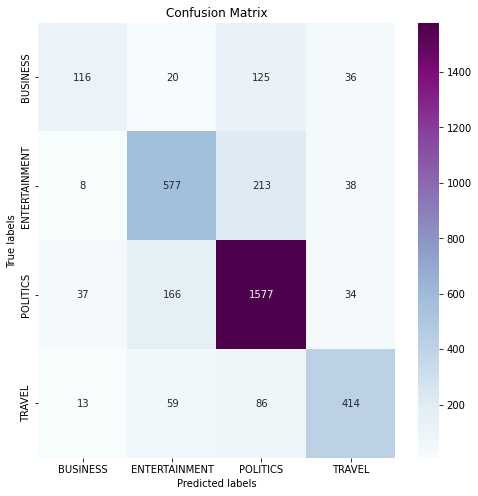

In [63]:
    # Plot confusion matrix
    cm = confusion_matrix(y_test, predicted_lgbm_embed)
    plt.figure(figsize=(8,8))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="BuPu")

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['BUSINESS', 'ENTERTAINMENT', 'POLITICS', 'TRAVEL'])
    ax.yaxis.set_ticklabels(['BUSINESS', 'ENTERTAINMENT', 'POLITICS', 'TRAVEL'])
    print("Light GradientBoosting Classifier performance with BERT embeddings:\n");

In [53]:
print('\nClassification Report\n')
print(classification_report(y_test, predicted_lgbm_embed
                            , target_names=['BUSINESS', 'ENTERTAINMENT', 'POLITICS', 'TRAVEL']))


Classification Report

               precision    recall  f1-score   support

     BUSINESS       0.67      0.39      0.49       297
ENTERTAINMENT       0.70      0.69      0.70       836
     POLITICS       0.79      0.87      0.83      1814
       TRAVEL       0.79      0.72      0.76       572

     accuracy                           0.76      3519
    macro avg       0.74      0.67      0.69      3519
 weighted avg       0.76      0.76      0.76      3519



#### (**!**) We were able to get great accuracy increase of 11 percentage point (from 0.65 to 0.76) just using BERT model for feature generation.